<a href="https://colab.research.google.com/github/AnitaTasnim/GNN_attack_model/blob/main/GNN_attack_model_with_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from deeprobust.graph.data import Dataset, Dpr2Pyg, Pyg2Dpr
data = Dataset(root=r'F:\py_res', name='cora') # load clean graph
pyg_data = Dpr2Pyg(data) # convert dpr to pyg
data = pyg_data[0]
data

Loading cora dataset...
Selecting 1 largest connected components


Processing...
Done!
f:\py_res\venv2\lib\site-packages\torch_geometric\data\in_memory_dataset.py:284: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(x=[2485, 1433], edge_index=[2, 10138], y=[2485], train_mask=[2485], val_mask=[2485], test_mask=[2485])

In [ ]:
import torch
import torch.nn as nn
from torch.nn import init
import torch_geometric
# from pygod.utils import load_data
from torch_geometric.data import Data
from torch_geometric.transforms import NormalizeFeatures

In [ ]:
torch.manual_seed(0)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device

device(type='cuda')

In [ ]:
import networkx as nx

# Create a NetworkX graph from the PyTorch Geometric data
G = nx.Graph()
G.add_edges_from(data.edge_index.T.tolist())

# Find disconnected components in the graph
disconnected_components = list(nx.connected_components(G))

# Print the number of disconnected components and the size of each component
print(f"Number of disconnected components: {len(disconnected_components)}")
for i, component in enumerate(disconnected_components):
    print(f"Component {i + 1} size: {len(component)}")

Number of disconnected components: 1
Component 1 size: 2485


In [ ]:
# Get the adjacency matrix, features, and labels
adj = data.edge_index.t()
features = data.x
labels = data.y

# Get the train, validation, and test indices
idx_train = data.train_mask.nonzero().view(-1)
idx_val = data.val_mask.nonzero().view(-1)
idx_test = data.test_mask.nonzero().view(-1)

# Print some dataset statistics
print(f"Number of nodes: {len(features)}")
print(f"Number of edges: {len(adj) // 2}")  # Divide by 2 because the graph is undirected
print(f"Number of features per node: {features.size(1)}")
print(f"Number of classes: {int(labels.max()) + 1}")
print(f"Number of training nodes: {len(idx_train)}")
print(f"Number of validation nodes: {len(idx_val)}")
print(f"Number of test nodes: {len(idx_test)}")

Number of nodes: 2485
Number of edges: 5069
Number of features per node: 1433
Number of classes: 7
Number of training nodes: 247
Number of validation nodes: 249
Number of test nodes: 1988


In [ ]:
import numpy as np
idx_unlabeled = np.union1d(idx_val, idx_test)
idx_unlabeled[:10]


array([ 0,  1,  2,  4,  5,  7,  8,  9, 10, 11], dtype=int64)

In [ ]:
import random
target_number = 40
node_list = random.sample(list(idx_unlabeled),target_number)
node_list

[2214,
 104,
 857,
 2108,
 336,
 2280,
 2220,
 2391,
 1891,
 2313,
 973,
 293,
 919,
 932,
 1332,
 1536,
 1676,
 1305,
 660,
 1422,
 878,
 1445,
 1128,
 2315,
 1045,
 2400,
 1821,
 2406,
 664,
 1437,
 1620,
 1970,
 2083,
 2006,
 2215,
 102,
 1739,
 2343,
 1548,
 1083]

In [ ]:

degree_cora = {}
for (u, v) in adj:
    if int(u) in degree_cora:
        degree_cora[int(u)] += 1
    else:
        degree_cora[int(u)] = 1


In [ ]:
budget_range = 25
# node_list_new = node_list.copy()
# for idx in range(len(node_list)):
#     if degree_cora[node_list[idx]] < budget_range+2:
#         node_list_new.remove(node_list[idx])

# need = target_number - len(node_list_new)
# while need:
#     tmp_list = random.sample(list(idx_unlabeled), 1)
#     if degree_cora[tmp_list[0]] > budget_range+2 and tmp_list[0] not in node_list_new:
#         node_list_new.append(tmp_list[0])
#         need -= 1

# node_list = node_list_new.copy()
# len(node_list)


In [ ]:
for node in node_list:
    if degree_cora[node] < budget_range:
        print(node)

2214
104
857
2108
336
2280
2220
1891
2313
973
293
919
932
1332
1536
1676
1305
660
1422
878
1445
1128
2315
1045
2400
1821
664
1437
1620
1970
2083
2006
2215
102
1739
1548
1083


In [ ]:
from torch_geometric.nn import GCNConv
from torch.nn import Linear, BatchNorm1d
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.bn2 = BatchNorm1d(hidden_channels * 2)
        self.conv3 = GCNConv(hidden_channels * 2, hidden_channels * 4)
        self.bn3 = BatchNorm1d(hidden_channels * 4)
        self.conv4 = GCNConv(hidden_channels * 4, hidden_channels * 2)
        self.bn4 = BatchNorm1d(hidden_channels * 2)
        self.out = Linear(hidden_channels * 2, num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Third Message Passing Layer
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Fourth Message Passing Layer
        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer
        x = self.out(x)
        x = F.softmax(x, dim=1)
        return x


Epoch 20/200:
Train Loss: 1.2115, Train Accuracy: 0.9717, Train Precision: 0.9717, Train Recall: 0.9717
Validation Loss: 1.3982, Validation Accuracy: 0.7751, Validation Precision: 0.7751, Validation Recall: 0.7751
Test Loss: 1.3769, Test Accuracy: 0.7948, Test Precision: 0.7948, Test Recall: 0.7948

Epoch 40/200:
Train Loss: 1.1847, Train Accuracy: 0.9838, Train Precision: 0.9838, Train Recall: 0.9838
Validation Loss: 1.3976, Validation Accuracy: 0.7671, Validation Precision: 0.7671, Validation Recall: 0.7671
Test Loss: 1.3844, Test Accuracy: 0.7752, Test Precision: 0.7752, Test Recall: 0.7752

Epoch 60/200:
Train Loss: 1.1841, Train Accuracy: 0.9838, Train Precision: 0.9838, Train Recall: 0.9838
Validation Loss: 1.3935, Validation Accuracy: 0.7871, Validation Precision: 0.7871, Validation Recall: 0.7871
Test Loss: 1.4008, Test Accuracy: 0.7847, Test Precision: 0.7847, Test Recall: 0.7847

Epoch 80/200:
Train Loss: 1.1842, Train Accuracy: 0.9879, Train Precision: 0.9879, Train Recall: 

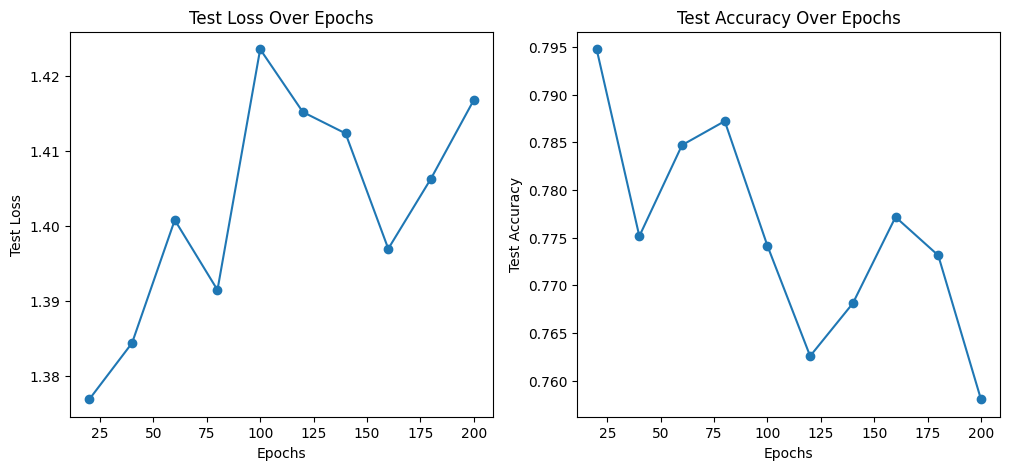

In [ ]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Initialize the model and optimizer
num_features = features.size(1)
num_classes = int(labels.max()) + 1
hidden_channels = 64  # You can adjust this as needed
model = GCN(num_features, hidden_channels, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Define a function for evaluation
def evaluate(model, features,adj,labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features, adj.t())
        logits = logits[mask]
        labels = labels[mask]
        pred = logits.max(1)[1]
        accuracy = accuracy_score(labels, pred)
        precision = precision_score(labels, pred, average='micro')
        recall = recall_score(labels, pred, average='micro')
        return accuracy, precision, recall

# Training loop
num_epochs = 200
train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

best_test_accuracy = 0.0
best_model_state = None

for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()
    logits = model(features, adj.t())
    loss = F.cross_entropy(logits[idx_train], labels[idx_train])
    loss.backward()
    optimizer.step()

    if epoch % 20 == 0:
        train_loss = loss.item()
        val_loss = F.cross_entropy(logits[idx_val], labels[idx_val]).item()
        test_loss = F.cross_entropy(logits[idx_test], labels[idx_test]).item()

        train_accuracy, train_precision, train_recall = evaluate(model, features,adj,labels, idx_train)
        val_accuracy, val_precision, val_recall = evaluate(model, features,adj,labels, idx_val)
        test_accuracy, test_precision, test_recall = evaluate(model, features,adj,labels, idx_test)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Epoch {epoch}/{num_epochs}:")
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}")
        print("")

        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_model_state = model.state_dict()

# Load the best model state
model.load_state_dict(best_model_state)


# Plot test loss and accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(20, num_epochs + 1, 20), test_losses, marker='o')
plt.title('Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Loss')

plt.subplot(1, 2, 2)
plt.plot(range(20, num_epochs + 1, 20), test_accuracies, marker='o')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.show()


In [ ]:
degree_cora = {}
for (u, v) in adj:
    if int(u) in degree_cora:
        degree_cora[int(u)] += 1
    else:
        degree_cora[int(u)] = 1

degree_cora[400]


3

### Autoencoder

In [ ]:
import torch_geometric.transforms as T
from torch_geometric.nn import GAE, VGAE, GCNConv
import time


In [ ]:
data

Data(x=[2485, 1433], edge_index=[2, 10138], y=[2485], train_mask=[2485], val_mask=[2485], test_mask=[2485])

In [ ]:
# Normalize node features
normalizer = T.NormalizeFeatures()
normalize_data = normalizer(data)

# Apply RandomLinkSplit transformation
splitter = T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, split_labels=True, add_negative_train_samples=False)
split_data = splitter(normalize_data)

# Split data into train, validation, and test sets
train_data, val_data, test_data = split_data

In [ ]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)


class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


class LinearEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        return self.conv(x, edge_index)


class VariationalLinearEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_mu = GCNConv(in_channels, out_channels)
        self.conv_logstd = GCNConv(in_channels, out_channels)

    def forward(self, x, edge_index):
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


In [ ]:
in_channels, out_channels = data.num_features, 16
threshold = 0.90

### GAE

In [ ]:
model_2 = GAE(GCNEncoder(in_channels, out_channels))
model_2 = model_2.to(device)
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.01)
epochs = 1000
variational = False

In [ ]:
def train():
    model_2.train()
    optimizer.zero_grad()
    z = model_2.encode(train_data.x.to(device), train_data.edge_index.to(device))
    loss = model_2.recon_loss(z, train_data.pos_edge_label_index)
    if variational:
        loss = loss + (1 / train_data.num_nodes) * model_2.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model_2.eval()
    z = model_2.encode(data.x.to(device), data.edge_index.to(device))
    return model_2.test(z, data.pos_edge_label_index, data.neg_edge_label_index)


times = []
for epoch in range(1, epochs + 1):
    start = time.time()
    loss = train()
    auc, ap = test(test_data)
    if epoch%100 == 0:
        print(f'Epoch: {epoch:03d}, AUC: {auc:.4f}, AP: {ap:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")


Epoch: 100, AUC: 0.8560, AP: 0.8562
Epoch: 200, AUC: 0.9141, AP: 0.9090
Epoch: 300, AUC: 0.9149, AP: 0.9119
Epoch: 400, AUC: 0.9204, AP: 0.9180
Epoch: 500, AUC: 0.9257, AP: 0.9213
Epoch: 600, AUC: 0.9205, AP: 0.9183
Epoch: 700, AUC: 0.9216, AP: 0.9203
Epoch: 800, AUC: 0.9197, AP: 0.9208
Epoch: 900, AUC: 0.9229, AP: 0.9229
Epoch: 1000, AUC: 0.9256, AP: 0.9255
Median time per epoch: 0.0786s


In [ ]:
encoded = model_2.encode(data.x.to(device), data.edge_index.to(device))
encoded

tensor([[ -8.5017,   2.8498,   2.7380,  ...,   9.6017,   5.1377,  -0.3366],
        [ -2.1881,  -5.9886,  -1.2439,  ...,  -7.6302,   2.4734, -14.8932],
        [  9.1062,   1.3975,  -3.4290,  ...,   3.7733,   0.1925,   1.8595],
        ...,
        [-14.0071,  -3.0482,  -2.1223,  ...,  -4.7959,  -4.8846,   1.9943],
        [ -6.4030,  -3.2462,   8.7629,  ...,  -8.4573, -11.8975,   1.4929],
        [ -9.0784,  -2.2755,  -0.8194,  ...,  -2.9549,  -2.9516,   0.2743]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
decoded = model_2.decoder(encoded, data.edge_index)
decoded.shape

torch.Size([10138])

In [ ]:
decoded[0]

tensor(1., device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
reshaped_edge_index = torch.transpose(data.edge_index, 0, 1)
decoded_edge_index_list = []
for i in range(len(decoded)):
    if decoded[i] > threshold:
#         print(reshaped_edge_index[i])
        decoded_edge_index_list.append(list(reshaped_edge_index[i]))

decoded_edge_index = torch.tensor(decoded_edge_index_list, dtype=torch.long).t()
len(decoded_edge_index[0])


10138

### VGAE

In [ ]:
model_3 = VGAE(VariationalGCNEncoder(in_channels, out_channels))
model_3


VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GCNConv(1433, 32)
    (conv_mu): GCNConv(32, 16)
    (conv_logstd): GCNConv(32, 16)
  )
  (decoder): InnerProductDecoder()
)

In [ ]:
model_3 = model_3.to(device)
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.01)
epochs = 1000
variational = True


In [ ]:
def train():
    model_3.train()
    optimizer.zero_grad()
    z = model_3.encode(train_data.x.to(device), train_data.edge_index.to(device))
    loss = model_3.recon_loss(z, train_data.pos_edge_label_index)
    if variational:
        loss = loss + (1 / train_data.num_nodes) * model_3.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test(data):
    model_3.eval()
    z = model_3.encode(data.x.to(device), data.edge_index.to(device))
    return model_3.test(z, data.pos_edge_label_index, data.neg_edge_label_index)


times = []
for epoch in range(1, epochs + 1):
    start = time.time()
    loss = train()
    auc, ap = test(test_data)
    if epoch%100 == 0:
        print(f'Epoch: {epoch:03d}, AUC: {auc:.4f}, AP: {ap:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")


Epoch: 100, AUC: 0.8375, AP: 0.8350
Epoch: 200, AUC: 0.8579, AP: 0.8517
Epoch: 300, AUC: 0.8833, AP: 0.8809
Epoch: 400, AUC: 0.9027, AP: 0.8992
Epoch: 500, AUC: 0.9115, AP: 0.9076
Epoch: 600, AUC: 0.9131, AP: 0.9118
Epoch: 700, AUC: 0.9185, AP: 0.9159
Epoch: 800, AUC: 0.9194, AP: 0.9200
Epoch: 900, AUC: 0.9168, AP: 0.9190
Epoch: 1000, AUC: 0.9184, AP: 0.9208
Median time per epoch: 0.0760s


In [ ]:
encoded_2 = model_3.encode(data.x.to(device), data.edge_index.to(device))
encoded_2


tensor([[-14.4340,  -3.4519,  -2.3777,  ...,   2.2983,   6.8737,   6.0512],
        [ -3.8723,  -4.5777,   6.7627,  ...,   0.9421,  -4.9893,   1.5404],
        [ -7.2275, -11.1031,   4.7453,  ...,   2.8315,  -6.6647,  -7.8439],
        ...,
        [  6.8083,   1.1795,  -0.0796,  ...,  -0.0394,  10.4528,  14.9204],
        [  3.8762,  -2.2522,   9.5996,  ...,   1.9222,   7.2805,  10.4537],
        [  3.7461,   0.7645,   0.7519,  ...,   1.2681,   6.9579,   9.7126]],
       device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
decoded_2 = model_3.decoder(encoded_2, data.edge_index)
decoded_2.shape

torch.Size([10138])

In [ ]:
reshaped_edge_index_2 = torch.transpose(data.edge_index, 0, 1)
decoded_edge_index_list_2 = []
for i in range(len(decoded_2)):
    if decoded_2[i] > threshold:
#         print(reshaped_edge_index[i])
        decoded_edge_index_list_2.append(list(reshaped_edge_index[i]))

decoded_edge_index_2 = torch.tensor(decoded_edge_index_list_2, dtype=torch.long).t()
len(decoded_edge_index_2[0])


10136

### edge_index analysis for most important edges

In [ ]:
edge_index_1 = decoded_edge_index
adj_list_1 = edge_index_1.t().tolist()
print(len(adj_list_1))

edge_index_2 = decoded_edge_index_2
adj_list_2 = edge_index_2.t().tolist()
print(len(adj_list_2))


10138
10136


In [ ]:
set1 = set(tuple(item) for item in adj_list_1)
set2 = set(tuple(item) for item in adj_list_2)

# Find the common elements using the intersection operation
common_elements = set1.intersection(set2)

# Convert the result back to a list of lists if needed
common_elements_list = [tuple(item) for item in common_elements]

# Print the common elements
print(len(common_elements_list))


10136


In [ ]:
node = node_list[0]
for (u, v) in common_elements_list:
    if u == node or v == node:
        print(f"{node} => ({u}, {v})")

2214 => (2177, 2214)
2214 => (2214, 2177)
2214 => (2214, 1908)
2214 => (1908, 2214)
2214 => (2214, 1907)
2214 => (2214, 1909)
2214 => (2214, 1590)
2214 => (1909, 2214)
2214 => (287, 2214)
2214 => (351, 2214)
2214 => (1907, 2214)
2214 => (1590, 2214)
2214 => (2214, 351)
2214 => (2214, 287)


In [ ]:
common_elements_list[:20]


[(1593, 363),
 (1687, 1688),
 (1164, 1647),
 (278, 1554),
 (2265, 1170),
 (781, 1882),
 (1638, 1008),
 (1469, 1236),
 (803, 1375),
 (450, 1782),
 (56, 2380),
 (775, 1313),
 (1523, 1701),
 (1855, 2174),
 (136, 1097),
 (962, 910),
 (1911, 1288),
 (13, 2195),
 (2112, 1049),
 (2371, 2212)]

In [ ]:
import networkx as nx

# Create a NetworkX graph from PyTorch Geometric data
G = nx.Graph()
G.add_edges_from(data.edge_index.T.tolist())

# Dictionary to store shortest distances for each node
shortest_distances = {}

# Calculate shortest distances for each node in the node list
for node in node_list:
    shortest_paths = nx.single_source_dijkstra_path_length(G, node)
    shortest_distances[node] = shortest_paths



In [ ]:
# Assuming `specific_node` is the node for which you want to find the top 5 highest distance nodes
specific_node = node_list[0]  # Replace this with the specific node index you want to consider

# Find the shortest distances from the specific node to all other nodes
if specific_node in shortest_distances:
    distances_from_specific_node = shortest_distances[specific_node]

    # Find the top 8 nodes with the highest shortest distances from the specific node
    top_8_nodes_from_specific_node = sorted(distances_from_specific_node.items(), key=lambda x: x[1], reverse=True)[:7]

    # Print or use the top 5 nodes
    print(f"Top 5 nodes with the highest shortest distances from Node {specific_node}:")
    for node, distance in top_8_nodes_from_specific_node:
        print(f"Node {node}: Shortest Distance = {distance}")
else:
    print(f"Node {specific_node} not found in the shortest_distances dictionary.")


Top 5 nodes with the highest shortest distances from Node 2214:
Node 1477: Shortest Distance = 14
Node 88: Shortest Distance = 13
Node 2022: Shortest Distance = 13
Node 454: Shortest Distance = 12
Node 921: Shortest Distance = 12
Node 923: Shortest Distance = 12
Node 1289: Shortest Distance = 12


### Both Add and Delete

In [ ]:
G = nx.Graph()
G.add_edges_from(adj)

def jaccard_similarity(graph, node1, node2):
    neighbors_node1 = set(graph.neighbors(node1))
    neighbors_node2 = set(graph.neighbors(node2))
    intersection = len(neighbors_node1.intersection(neighbors_node2))
    union = len(neighbors_node1.union(neighbors_node2))
    jaccard_similarity = intersection / union if union != 0 else 0
    return jaccard_similarity

target_node = node_list[0]
for node in G.nodes():
    if int(target_node) == int(node):
        target_node = node
        break


In [ ]:
jaccard_similarities = {}
for node in G.nodes():
    if node != target_node:
        similarity = jaccard_similarity(G, target_node, node)
        jaccard_similarities[node] = similarity


In [ ]:
unique_values = set(jaccard_similarities.values())
unique_values

{0.0}

In [ ]:
print(torch.tensor(425) in G.nodes())
len(G.nodes())

False


20276

In [ ]:
for node in G.nodes():
    if int(node) == 425:
        print("Yes")

Yes
Yes


In [ ]:
# import torch
# import torch.nn.functional as F
# import networkx as nx

# # Load the Cora dataset as a NetworkX graph
# G = nx.Graph()
# G.add_edges_from(adj)
# num_nodes = len(G.nodes())

# # Pre-trained model (assuming you have already trained the model)
# # model = torch.load('model.pth')
# model.eval()

# # Single target node ID
# target_node_id = node_list[0]
# for node in G.nodes():
#     if int(target_node) == int(node):
#         target_node = node
#         break

# # Compute the target node's embedding
# with torch.no_grad():
#     target_node_features = torch.FloatTensor(features[target_node_id])  # Replace 'feature' with your node feature key
#     target_node_embedding = model(target_node_features)

# # Compute addition scores for potential edges
# addition_scores = {}
# for candidate_node_id in range(num_nodes):
#     if candidate_node_id != target_node_id and not G.has_edge(target_node_id, candidate_node_id):
#         # Add a potential edge
#         G_with_edge = G.copy()
#         G_with_edge.add_edge(target_node_id, candidate_node_id)

#         # Compute the new target node's embedding
#         with torch.no_grad():
#             new_target_node_features = torch.FloatTensor([G_with_edge.nodes[str(target_node_id)]['feature']])  # Replace 'feature' with your node feature key
#             new_target_node_embedding = model(new_target_node_features)

#         # Compute the addition score (negative change in classification score)
#         addition_score = torch.norm(target_node_embedding - new_target_node_embedding, p=2)  # L2 norm
#         addition_scores[candidate_node_id] = addition_score.item()

# # Sort potential nodes by addition score in ascending order
# candidate_nodes = sorted(addition_scores.keys(), key=lambda x: addition_scores[x])

# print("Candidate Nodes for IG-Attack (Target Node ID:", target_node_id, "):", candidate_nodes)


In [ ]:
degree_cora = {}
for (u, v) in data.edge_index.t():
    if int(u) in degree_cora:
        degree_cora[int(u)] += 1
    else:
        degree_cora[int(u)] = 1

def eval(model, features,adj,labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features, adj.t())
        logits = logits[mask]
        labels = labels[mask]
        pred = torch.argmax(logits)
        accuracy = 1 if int(labels) == int(pred) else 0
        return accuracy

def eval_2(model, features,adj,labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features, adj.t())
        logits = logits[mask]
        labels = labels[mask]
        pred = logits.max(1)[1]
        accuracy = accuracy_score(labels, pred)
        return accuracy

def evaluate(model, features,adj,labels, mask):
    num_epochs = 100
    model = GCN(num_features, hidden_channels, num_classes)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()
        logits = model(features, adj.t())
        loss = F.cross_entropy(logits[idx_train], labels[idx_train])
        loss.backward()
        optimizer.step()

        if epoch % 20 == 0:
            train_loss = loss.item()
            val_loss = F.cross_entropy(logits[idx_val], labels[idx_val]).item()
            test_loss = F.cross_entropy(logits[idx_test], labels[idx_test]).item()

            train_accuracy = eval_2(model, features,adj,labels, idx_train)
            val_accuracy = eval_2(model, features,adj,labels, idx_val)
            test_accuracy = eval_2(model, features,adj,labels, idx_test)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            test_losses.append(test_loss)

            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            test_accuracies.append(test_accuracy)

            print(f"Epoch {epoch}/{num_epochs}:")
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
            print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
            print("")

    accuracy = eval(model, features,adj,labels, mask)
    return accuracy


def get_nodes_to_connect_by_distance(adj, target_node, budget):
    G = nx.Graph()
    G.add_edges_from(adj)

    # Dictionary to store shortest distances for each node
    shortest_distances = {}

    source_node = target_node
    label = labels[source_node]

    # Calculate shortest distances for each node in the node list
    shortest_paths = nx.single_source_dijkstra_path_length(G, target_node)
    shortest_distances[target_node] = shortest_paths
    distances_from_specific_node = shortest_distances[source_node]
    top_nodes_from_specific_node = sorted(distances_from_specific_node.items(), key=lambda x: x[1], reverse=True)

    nodes_to_connect = []



    for node in top_nodes_from_specific_node:
        if labels[node[0]] != label:
            print(f'Distance between {target_node} and {node[0]} is {node[1]}')
            return node[0]
            # nodes_to_connect.append(node[0])
            # break

    print(shortest_distances, len(adj))
    print(shortest_paths)

    print("Nothing found!!")
    #     if len(nodes_to_connect) > budget:
    #         break

    # # Find the shortest distances from the specific node to all other nodes
    # if source_node in shortest_distances:
    #     distances_from_specific_node = shortest_distances[source_node]

    #     # Find the top 8 nodes with the highest shortest distances from the specific node
    #     top_nodes_from_specific_node = sorted(distances_from_specific_node.items(), key=lambda x: x[1], reverse=True)

    #     for node in top_nodes_from_specific_node:
    #         if labels[node[0]] != label:
    #             nodes_to_connect.append(node[0])

    #         if len(nodes_to_connect) > budget:
    #             break
    # return top_nodes_from_specific_node[0][0]

def modify_adj(target_node, adj, budget, model, features, labels, isBoth=0, isAdd=0, isRemove=0):

    # degree = degree_cora.copy()

    G = nx.Graph()
    G.add_edges_from(adj.tolist())

    degree = dict(nx.degree(G))



    prune_list = []
    for (u, v) in common_elements_list:
        if (u == target_node or v == target_node):
            if (u, v) not in prune_list:
                prune_list.append((u, v))
            if (v, u) not in prune_list:
                prune_list.append((v, u))

    final_prune_list = prune_list.copy()

    # print("1: ",len(final_prune_list))

    i = 0
    while i < len(prune_list):
        u, v = map(int, prune_list[i])

        if u in degree and degree[u] > 1:
            degree[u] -= 1
        else:
#             print('Okay')
            final_prune_list = [lst for lst in final_prune_list if lst != prune_list[i]]
            if prune_list[i] in final_prune_list:
                print("why here bro!")

        if v in degree and degree[v] > 1:
            degree[v] -= 1
        else:
#             print('Okay')
            final_prune_list = [lst for lst in final_prune_list if lst != prune_list[i]]
            if prune_list[i] in final_prune_list:
                print("why here bro!")

        i += 1

    updated_edges = adj.tolist()
    final_prune_list_tmp = final_prune_list.copy()

    cnt1 = 0
    cnt2 = 0
    isLimitOver = 0
    degree = dict(nx.degree(G))
    while budget:
        flg_d, flg_a = 0, 0
        if (isBoth or isRemove) and isLimitOver==0:
            updated_edges_tmp_2 = updated_edges.copy()
            try:
                edge_to_remove_1 = list(final_prune_list[0])
            except:
                isAddNewEdge=0
                tmp = updated_edges.copy()
                for (u, v) in tmp:
                    if (u == target_node or v == target_node) and ((u, v) not in final_prune_list_tmp):
                        if degree[u] <= 1 or degree[v] <= 1:
                            continue
                        print(f"({u}, {v}) is not important but I am removing this anyway. ")
                        edge_to_remove_1 = [u, v]
                        isAddNewEdge=1
                        final_prune_list_tmp.append((u, v))
                        break
                if isAddNewEdge == 0:
                    print("Limit for removing edge is over..")
                    isLimitOver = 1
            if isLimitOver == 0:
                edge_to_remove_2 = [edge_to_remove_1[1], edge_to_remove_1[0]]
                # updated_edges_tmp_2.remove(edge_to_remove_1)
                # updated_edges_tmp_2.remove(edge_to_remove_2)
                # final_prune_list.remove(tuple(edge_to_remove_1))
                # final_prune_list.remove(tuple(edge_to_remove_2))
                flg = 0

                try:
                    updated_edges_tmp_2.remove(edge_to_remove_1)
                    flg = 1
                    degree[edge_to_remove_1[0]]-=1
                    # print('okay1')
                except:
                    pass

                try:
                    updated_edges_tmp_2.remove(edge_to_remove_2)
                    flg = 1
                    degree[edge_to_remove_2[0]]-=1
                    # print('okay2')
                except:
                    pass

                try:
                    final_prune_list.remove(tuple(edge_to_remove_1))
                except:
                    pass

                try:
                    final_prune_list.remove(tuple(edge_to_remove_2))
                except:
                    pass

                if flg==0:
                    print("Not removed any egdes.")
                else:
                    pass
                    # print(f"removed edge {edge_to_remove_1}")
                G = nx.Graph()
                G.add_edges_from(updated_edges_tmp_2)

                # Check if the graph is connected
                is_connected = nx.is_connected(G)

                # assert is_connected, "Graph is disconnected."
                if not is_connected:
                    isLimitOver = 1
                    updated_edges_tmp_2 = updated_edges.copy()
                modified_adj = torch.tensor(updated_edges_tmp_2, dtype=torch.long)

                accuracy = evaluate(model, features, modified_adj, labels, target_node)
                flg_d = 1 if accuracy == 0 else 0
                # print("============,", len(final_prune_list))
                if accuracy == 0:
                    print(f"added val: {flg_a}, removed val: {flg_d}")
                    print(f"added: {cnt1}, removed: {cnt2+1}")
                    return accuracy

        if isBoth or isAdd:
            updated_edges_tmp = updated_edges.copy()
            edge_to_add = get_nodes_to_connect_by_distance(updated_edges_tmp, target_node, budget)
            updated_edges_tmp.append([target_node, edge_to_add])
            # nodes_to_connect.remove(edge_to_add)
            # print(f"added edge {edge_to_add}")

            modified_adj = torch.tensor(updated_edges_tmp, dtype=torch.long)
            try:
                accuracy = evaluate(model, features, modified_adj, labels, target_node)
                flg_a = 1 if accuracy == 0 else 0
                if accuracy == 0:
                    print(f"added val: {flg_a}, removed val: {flg_d}")
                    print(f"added: {cnt1+1}, removed: {cnt2}")
                    return accuracy
            except:
                pass

            # print("end of loop")
        if isBoth:
            if flg_a or isLimitOver:
                cnt1 += 1
                print("Len before add: ", len(updated_edges))
                updated_edges = updated_edges_tmp.copy()
                print("Len after add: ", len(updated_edges))
            else:
                cnt2 += 1
                print("Len before delete: ", len(updated_edges))
                updated_edges = updated_edges_tmp_2.copy()
                print("Len after delete: ", len(updated_edges))

            print(f"added val: {flg_a}, removed val: {flg_d}")
        elif isAdd:
            cnt1+=1
            updated_edges = updated_edges_tmp.copy()
        else:
            if isLimitOver:
                break
            cnt2+=1
            updated_edges = updated_edges_tmp_2.copy()

        budget -= 1


    print(f"added: {cnt1}, removed: {cnt2}")

    modified_adj = torch.tensor(updated_edges, dtype=torch.long)
    accuracy = evaluate(model, features, modified_adj, labels, target_node)
    return accuracy

    # return torch.tensor(updated_edges, dtype=torch.long)

In [ ]:
# budget_range = 7

acc_list = []
acc_node = {}

for budget in range(1, budget_range+1):
    print(f"For budget number: {budget}")

    cnt = 0
    curr_acc = {1:[], 0:[]}
    for target_node in node_list:
        print(f'Target node: {target_node}')
        # modified_adj = modify_adj(target_node, adj, budget, model, features, labels, isBoth=1)
        # accuracy = evaluate(model, features, modified_adj, labels, target_node)

        accuracy = modify_adj(target_node, adj, budget, model, features, labels, isBoth=1)
        print("accuracy = ", accuracy)
        if accuracy == 0:
            curr_acc[0].append(target_node)
            cnt += 1
        else:
            curr_acc[1].append(target_node)

    acc_node[budget] = curr_acc
    acc_list.append([budget, cnt / len(node_list), node_list])

    print(f"Total Target: {target_number}")
    print('Miss-classification rate Modified : %s' % (cnt / len(node_list)))

cnt = 0
curr_acc = {1:[], 0:[]}
for target_node in node_list:
    accuracy = evaluate(model, features, adj, labels, target_node)

    if accuracy == 0:
        curr_acc[0].append(target_node)
        cnt += 1
    else:
        curr_acc[1].append(target_node)

print('Miss-classification rate : %s' % (cnt / len(node_list)))

For budget number: 1
Target node: 2214
Epoch 20/100:
Train Loss: 1.2495, Train Accuracy: 0.9150
Validation Loss: 1.4068, Validation Accuracy: 0.7430
Test Loss: 1.4139, Test Accuracy: 0.7389

Epoch 40/100:
Train Loss: 1.2479, Train Accuracy: 0.9190
Validation Loss: 1.4302, Validation Accuracy: 0.7390
Test Loss: 1.4301, Test Accuracy: 0.7399

Epoch 60/100:
Train Loss: 1.2420, Train Accuracy: 0.9190
Validation Loss: 1.4246, Validation Accuracy: 0.7390
Test Loss: 1.4115, Test Accuracy: 0.7560

Epoch 80/100:
Train Loss: 1.1916, Train Accuracy: 0.9798
Validation Loss: 1.4221, Validation Accuracy: 0.7751
Test Loss: 1.4164, Test Accuracy: 0.7671

Epoch 100/100:
Train Loss: 1.1838, Train Accuracy: 0.9879
Validation Loss: 1.4103, Validation Accuracy: 0.7510
Test Loss: 1.3988, Test Accuracy: 0.7621

added val: 0, removed val: 1
added: 0, removed: 1
accuracy =  0
Target node: 104
Limit for removing edge is over..
Distance between 104 and 88 is 15
Epoch 20/100:
Train Loss: 1.2453, Train Accuracy: 0

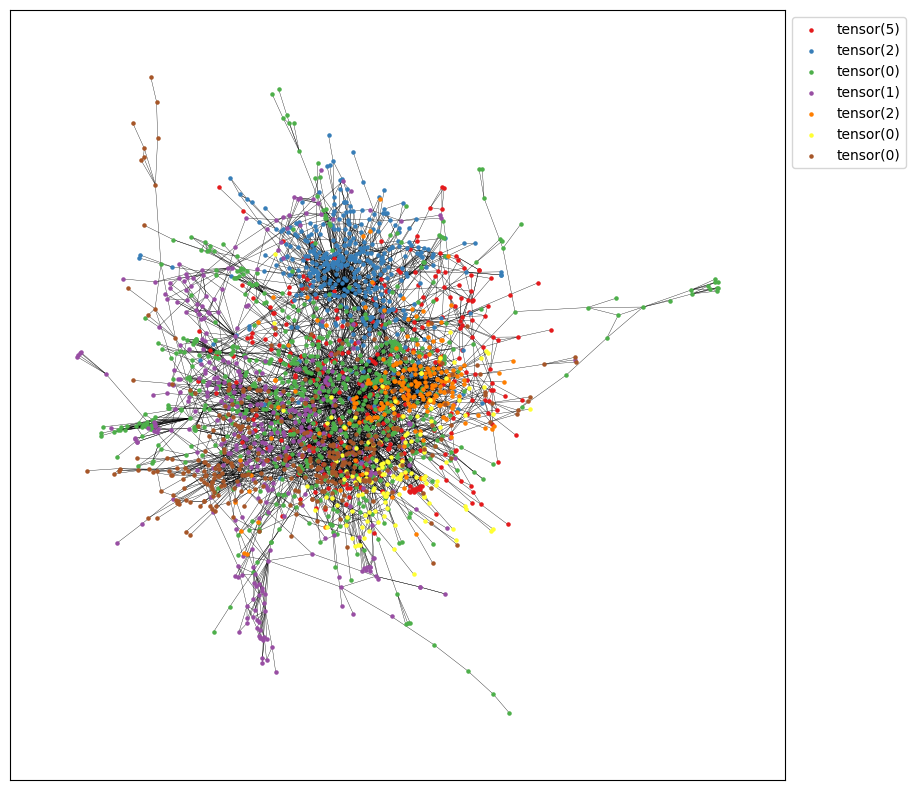

In [ ]:

from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected=True)
node_color = []
nodelist = [[], [], [], [], [], [], []]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628']
labels = data.y
for n, i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)
pos = nx.spring_layout(G, seed = 42)
plt.figure(figsize = (10, 10))
labellist = list(labels)
for num, i in enumerate(zip(nodelist, labellist)):
    n, l = i[0], i[1]
    nx.draw_networkx_nodes(G, pos, nodelist=n, node_size = 5, node_color = colorlist[num], label=l)
nx.draw_networkx_edges(G, pos, width = 0.25)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')

In [ ]:
torch.unique(labels)

tensor([0, 1, 2, 3, 4, 5, 6])

In [ ]:
# for (u, v) in common_elements_list:
#     if u == target_node or v == target_node:
#         print(f"{node} => ({u}, {v})")

In [ ]:
import pandas as pd

df_1 = pd.DataFrame(acc_list, columns =['budget_number', 'miss-classification_modified', 'node_list'])
df_1.head()
df_1.to_csv('our_model_1.csv') ## please change the number accordingly

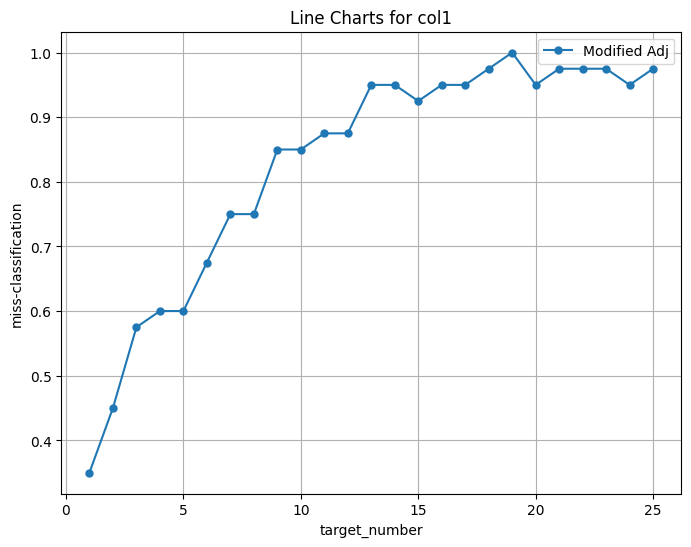

In [ ]:
# Create two line charts for col1 and col2
plt.figure(figsize=(8, 6))

# Line chart for col1
plt.plot(df_1['budget_number'], df_1['miss-classification_modified'], label='Modified Adj', marker='o', markersize=5, linestyle='-')

# plt.ylim(bottom=0.10, top=0.50)

# Add labels and a legend
plt.xlabel('target_number')
plt.ylabel('miss-classification')
plt.title('Line Charts for col1')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
from deeprobust.graph.targeted_attack import FGA
from deeprobust.graph.data import Dataset
import matplotlib.pyplot as plt


data2 = Dataset(root='/tmp/', name='cora')
adj2, features2, labels2 = data2.adj, data2.features, data2.labels
idx_train2, idx_val2, idx_test2 = data2.idx_train, data2.idx_val, data2.idx_test


Loading cora dataset...
Selecting 1 largest connected components


In [ ]:
from deeprobust.graph.defense import GCN
target_number = len(node_list)
acc_list = []
acc_node = {}

def test1(adj, features, target_node):
    ''' test on GCN '''
    gcn = GCN(nfeat=features.shape[1], nhid=16, nclass=labels2.max().item() + 1, dropout=0.5, device=device)
    gcn = gcn.to(device)
    gcn.fit(features, adj, labels2, idx_train2, idx_val2, patience=30, train_iters=100)
    gcn.eval()
    output = gcn.predict()
    probs = torch.exp(output[[target_node]])[0]
    # acc_test = accuracy(output[[target_node]], labels[target_node])
    acc_test = (output.argmax(1)[target_node] == labels2[target_node])
    # print('Target node probs: {}'.format(probs.detach().cpu().numpy()))
    # print(output.argmax(1)[target_node])
    # print(labels[target_node])
    #acc_test = accuracy(output[idx_test], labels[idx_test])

    #print("Overall test set results:",
     #     "accuracy= {:.4f}".format(acc_test.item()))

    return acc_test.item()


for budget in range(1, budget_range+1):
    print(f"For budget number: {budget}")

    cnt = 0
    curr_acc = {1:[], 0:[]}
    for target_node in node_list:
        print(f'Target node: {target_node}')
        surrogate = GCN(nfeat=features2.shape[1], nclass=labels2.max().item()+1, nhid=16, dropout=0, with_relu=False, with_bias=False, device=device).to(device)
        surrogate.fit(features2, adj2, labels2, idx_train2, idx_val2, patience=30, train_iters=100)
        model_attack = FGA(surrogate, nnodes=adj2.shape[0], attack_structure=True, attack_features=False, device=device).to(device)
        model_attack.attack(features2, adj2, labels2, idx_train2, target_node, n_perturbations=budget)

        modified_adj = model_attack.modified_adj

        accuracy = test1(modified_adj, features2, target_node)
        print("accuracy = ", accuracy)
        if accuracy == 0:
            curr_acc[0].append(target_node)
            cnt += 1
        else:
            curr_acc[1].append(target_node)

    acc_node[budget] = curr_acc
    acc_list.append([budget, cnt / len(node_list), node_list])

    print(f"Total Target: {target_number}")
    print('Miss-classification rate Modified : %s' % (cnt / len(node_list)))

cnt = 0
curr_acc = {1:[], 0:[]}
for target_node in node_list:
    accuracy = test1(adj2, features2, target_node)

    if accuracy == 0:
        curr_acc[0].append(target_node)
        cnt += 1
    else:
        curr_acc[1].append(target_node)

print('Miss-classification rate : %s' % (cnt / len(node_list)))

For budget number: 1
Target node: 2062
accuracy =  True
Target node: 1362
accuracy =  False
Target node: 1441
accuracy =  True
Target node: 1134
accuracy =  True
Target node: 2376
accuracy =  True
Target node: 2061
accuracy =  True
Target node: 809
accuracy =  True
Target node: 125
accuracy =  True
Target node: 1004
accuracy =  False
Target node: 40
accuracy =  True
Target node: 1788
accuracy =  True
Target node: 2185
accuracy =  True
Target node: 1665
accuracy =  False
Target node: 1416
accuracy =  False
Target node: 1587
accuracy =  False
Target node: 1369
accuracy =  False
Target node: 2091
accuracy =  True
Target node: 589
accuracy =  False
Target node: 300
accuracy =  False
Target node: 1115
accuracy =  True
Target node: 1753
accuracy =  False
Target node: 1288
accuracy =  True
Target node: 956
accuracy =  True
Target node: 1106
accuracy =  True
Target node: 405
accuracy =  False
Target node: 2056
accuracy =  True
Target node: 1088
accuracy =  True
Target node: 1513
accuracy =  Fa

In [ ]:
False == 0

True

In [ ]:
True == 1

True

In [ ]:
import pandas as pd

df_2 = pd.DataFrame(acc_list, columns =['budget_number', 'miss-classification_modified', 'node_list'])
df_2.head()
df_2.to_csv('FGA_1.csv') ## please change the number accordingly

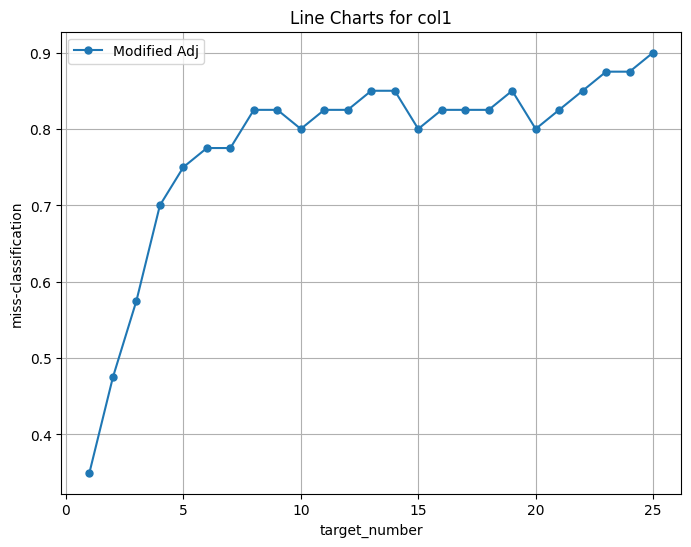

In [ ]:
# Create two line charts for col1 and col2
plt.figure(figsize=(8, 6))

# Line chart for col1
plt.plot(df_2['budget_number'], df_2['miss-classification_modified'], label='Modified Adj', marker='o', markersize=5, linestyle='-')

# plt.ylim(bottom=0.10, top=0.50)

# Add labels and a legend
plt.xlabel('target_number')
plt.ylabel('miss-classification')
plt.title('Line Charts for col1')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
from deeprobust.graph.targeted_attack import RND

acc_list = []
acc_node = {}

def test1(adj, features, target_node):
    ''' test on GCN '''
    gcn = GCN(nfeat=features.shape[1], nhid=16, nclass=labels2.max().item() + 1, dropout=0.5, device=device)
    gcn = gcn.to(device)
    gcn.fit(features, adj, labels2, idx_train2, idx_val2, patience=30, train_iters=100)
    gcn.eval()
    output = gcn.predict()
    probs = torch.exp(output[[target_node]])[0]
    # acc_test = accuracy(output[[target_node]], labels[target_node])
    acc_test = (output.argmax(1)[target_node] == labels2[target_node])
    # print('Target node probs: {}'.format(probs.detach().cpu().numpy()))
    # print(output.argmax(1)[target_node])
    # print(labels[target_node])
    #acc_test = accuracy(output[idx_test], labels[idx_test])

    #print("Overall test set results:",
     #     "accuracy= {:.4f}".format(acc_test.item()))

    return acc_test.item()


for budget in range(1, budget_range+1):
    print(f"For budget number: {budget}")

    cnt = 0
    curr_acc = {1:[], 0:[]}
    for target_node in node_list:
        print(f'Target node: {target_node}')
        model_attack = RND()
        model_attack.attack(adj2, labels2, idx_train2, target_node, n_perturbations=budget)

        modified_adj = model_attack.modified_adj

        accuracy = test1(modified_adj, features2, target_node)
        print("accuracy = ", accuracy)
        if accuracy == 0:
            curr_acc[0].append(target_node)
            cnt += 1
        else:
            curr_acc[1].append(target_node)

    acc_node[budget] = curr_acc
    acc_list.append([budget, cnt / len(node_list), node_list])

    print(f"Total Target: {target_number}")
    print('Miss-classification rate Modified : %s' % (cnt / len(node_list)))

cnt = 0
curr_acc = {1:[], 0:[]}
for target_node in node_list:
    accuracy = test1(adj2, features2, target_node)

    if accuracy == 0:
        curr_acc[0].append(target_node)
        cnt += 1
    else:
        curr_acc[1].append(target_node)

print('Miss-classification rate : %s' % (cnt / len(node_list)))

For budget number: 1
Target node: 2062
number of pertubations: 1
accuracy =  True
Target node: 1362
number of pertubations: 1
accuracy =  True
Target node: 1441
number of pertubations: 1
accuracy =  True
Target node: 1134
number of pertubations: 1
accuracy =  True
Target node: 2376
number of pertubations: 1
accuracy =  True
Target node: 2061
number of pertubations: 1
accuracy =  True
Target node: 809
number of pertubations: 1
accuracy =  True
Target node: 125
number of pertubations: 1
accuracy =  True
Target node: 1004
number of pertubations: 1
accuracy =  False
Target node: 40
number of pertubations: 1
accuracy =  False
Target node: 1788
number of pertubations: 1
accuracy =  True
Target node: 2185
number of pertubations: 1
accuracy =  True
Target node: 1665
number of pertubations: 1
accuracy =  False
Target node: 1416
number of pertubations: 1
accuracy =  False
Target node: 1587
number of pertubations: 1
accuracy =  False
Target node: 1369
number of pertubations: 1
accuracy =  False
T

In [ ]:
import pandas as pd

df_3 = pd.DataFrame(acc_list, columns =['budget_number', 'miss-classification_modified', 'node_list'])
df_3.head()
df_3.to_csv('RND_1.csv') ## please change the number accordingly

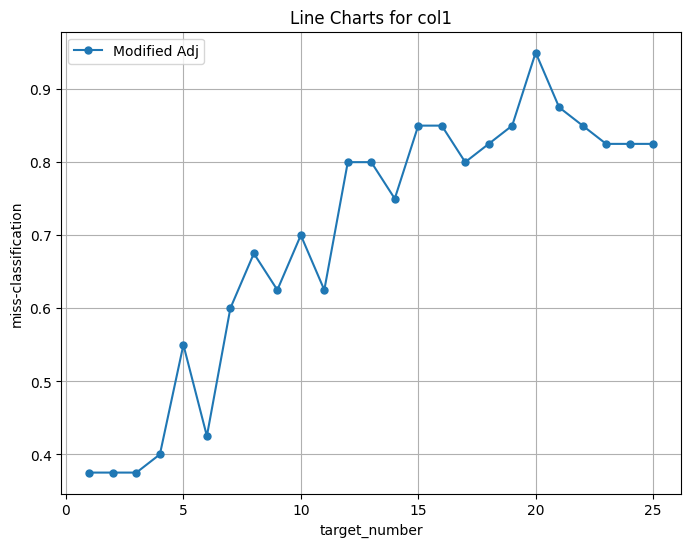

In [ ]:
# Create two line charts for col1 and col2
plt.figure(figsize=(8, 6))

# Line chart for col1
plt.plot(df_3['budget_number'], df_3['miss-classification_modified'], label='Modified Adj', marker='o', markersize=5, linestyle='-')

# plt.ylim(bottom=0.10, top=0.50)

# Add labels and a legend
plt.xlabel('target_number')
plt.ylabel('miss-classification')
plt.title('Line Charts for col1')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

#### Time and Memory

In [ ]:
num_epochs=200

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels * 2)
        self.bn2 = BatchNorm1d(hidden_channels * 2)
        self.conv3 = GCNConv(hidden_channels * 2, hidden_channels * 4)
        self.bn3 = BatchNorm1d(hidden_channels * 4)
        self.conv4 = GCNConv(hidden_channels * 4, hidden_channels * 2)
        self.bn4 = BatchNorm1d(hidden_channels * 2)
        self.out = Linear(hidden_channels * 2, num_classes)

    def forward(self, x, edge_index):
        # First Message Passing Layer (Transformation)
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Second Message Passing Layer
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Third Message Passing Layer
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Fourth Message Passing Layer
        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Output layer
        x = self.out(x)
        x = F.softmax(x, dim=1)
        return x

In [ ]:
degree_cora = {}
for (u, v) in data.edge_index.t():
    if int(u) in degree_cora:
        degree_cora[int(u)] += 1
    else:
        degree_cora[int(u)] = 1

def eval(model, features,adj,labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features, adj.t())
        logits = logits[mask]
        labels = labels[mask]
        pred = torch.argmax(logits)
        accuracy = 1 if int(labels) == int(pred) else 0
        return accuracy

def eval_2(model, features,adj,labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features, adj.t())
        logits = logits[mask]
        labels = labels[mask]
        pred = logits.max(1)[1]
        accuracy = accuracy_score(labels, pred)
        return accuracy

def evaluate(model, features,adj,labels, mask):
    num_epochs = 100
    model = GCN(num_features, hidden_channels, num_classes)
    optimizer = optim.Adam(model.parameters(), lr=0.01)


    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()
        logits = model(features, adj.t())
        loss = F.cross_entropy(logits[idx_train], labels[idx_train])
        loss.backward()
        optimizer.step()

        if epoch % 20 == 0:
            train_loss = loss.item()
            val_loss = F.cross_entropy(logits[idx_val], labels[idx_val]).item()
            test_loss = F.cross_entropy(logits[idx_test], labels[idx_test]).item()

            train_accuracy = eval_2(model, features,adj,labels, idx_train)
            val_accuracy = eval_2(model, features,adj,labels, idx_val)
            test_accuracy = eval_2(model, features,adj,labels, idx_test)

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            test_losses.append(test_loss)

            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            test_accuracies.append(test_accuracy)

            print(f"Epoch {epoch}/{num_epochs}:")
            print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
            print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
            print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
            print("")

    accuracy = eval(model, features,adj,labels, mask)
    return accuracy


def get_nodes_to_connect_by_distance(adj, target_node, budget):
    G = nx.Graph()
    G.add_edges_from(adj)

    # Dictionary to store shortest distances for each node
    shortest_distances = {}

    source_node = target_node
    label = labels[source_node]

    # Calculate shortest distances for each node in the node list
    shortest_paths = nx.single_source_dijkstra_path_length(G, target_node)
    shortest_distances[target_node] = shortest_paths
    distances_from_specific_node = shortest_distances[source_node]
    top_nodes_from_specific_node = sorted(distances_from_specific_node.items(), key=lambda x: x[1], reverse=True)

    nodes_to_connect = []



    for node in top_nodes_from_specific_node:
        if labels[node[0]] != label:
            print(f'Distance between {target_node} and {node[0]} is {node[1]}')
            return node[0]
            # nodes_to_connect.append(node[0])
            # break

    print(shortest_distances, len(adj))
    print(shortest_paths)

    print("Nothing found!!")

def modify_adj(target_node, adj, budget, model, features, labels, isBoth=0, isAdd=0, isRemove=0):

    # degree = degree_cora.copy()

    G = nx.Graph()
    G.add_edges_from(adj.tolist())

    degree = dict(nx.degree(G))



    prune_list = []
    for (u, v) in common_elements_list:
        if (u == target_node or v == target_node):
            if (u, v) not in prune_list:
                prune_list.append((u, v))
            if (v, u) not in prune_list:
                prune_list.append((v, u))

    final_prune_list = prune_list.copy()

    # print("1: ",len(final_prune_list))

    i = 0
    while i < len(prune_list):
        u, v = map(int, prune_list[i])

        if u in degree and degree[u] > 1:
            degree[u] -= 1
        else:
#             print('Okay')
            final_prune_list = [lst for lst in final_prune_list if lst != prune_list[i]]
            if prune_list[i] in final_prune_list:
                print("why here bro!")

        if v in degree and degree[v] > 1:
            degree[v] -= 1
        else:
#             print('Okay')
            final_prune_list = [lst for lst in final_prune_list if lst != prune_list[i]]
            if prune_list[i] in final_prune_list:
                print("why here bro!")

        i += 1

    updated_edges = adj.tolist()
    final_prune_list_tmp = final_prune_list.copy()

    cnt1 = 0
    cnt2 = 0
    isLimitOver = 0
    degree = dict(nx.degree(G))
    while budget:
        flg_d, flg_a = 0, 0
        if (isBoth or isRemove) and isLimitOver==0:
            updated_edges_tmp_2 = updated_edges.copy()
            try:
                edge_to_remove_1 = list(final_prune_list[0])
            except:
                isAddNewEdge=0
                tmp = updated_edges.copy()
                for (u, v) in tmp:
                    if (u == target_node or v == target_node) and ((u, v) not in final_prune_list_tmp):
                        if degree[u] <= 1 or degree[v] <= 1:
                            continue
                        print(f"({u}, {v}) is not important but I am removing this anyway. ")
                        edge_to_remove_1 = [u, v]
                        isAddNewEdge=1
                        final_prune_list_tmp.append((u, v))
                        break
                if isAddNewEdge == 0:
                    print("Limit for removing edge is over..")
                    isLimitOver = 1
            if isLimitOver == 0:
                edge_to_remove_2 = [edge_to_remove_1[1], edge_to_remove_1[0]]
                # updated_edges_tmp_2.remove(edge_to_remove_1)
                # updated_edges_tmp_2.remove(edge_to_remove_2)
                # final_prune_list.remove(tuple(edge_to_remove_1))
                # final_prune_list.remove(tuple(edge_to_remove_2))
                flg = 0

                try:
                    updated_edges_tmp_2.remove(edge_to_remove_1)
                    flg = 1
                    degree[edge_to_remove_1[0]]-=1
                    # print('okay1')
                except:
                    pass

                try:
                    updated_edges_tmp_2.remove(edge_to_remove_2)
                    flg = 1
                    degree[edge_to_remove_2[0]]-=1
                    # print('okay2')
                except:
                    pass

                try:
                    final_prune_list.remove(tuple(edge_to_remove_1))
                except:
                    pass

                try:
                    final_prune_list.remove(tuple(edge_to_remove_2))
                except:
                    pass

                if flg==0:
                    print("Not removed any egdes.")
                else:
                    pass
                    # print(f"removed edge {edge_to_remove_1}")
                G = nx.Graph()
                G.add_edges_from(updated_edges_tmp_2)

                # Check if the graph is connected
                is_connected = nx.is_connected(G)

                # assert is_connected, "Graph is disconnected."
                if not is_connected:
                    isLimitOver = 1
                    updated_edges_tmp_2 = updated_edges.copy()
                modified_adj = torch.tensor(updated_edges_tmp_2, dtype=torch.long)

                accuracy = evaluate(model, features, modified_adj, labels, target_node)
                flg_d = 1 if accuracy == 0 else 0
                # print("============,", len(final_prune_list))
                if accuracy == 0:
                    print(f"added val: {flg_a}, removed val: {flg_d}")
                    print(f"added: {cnt1}, removed: {cnt2+1}")
                    return accuracy

        if isBoth or isAdd:
            updated_edges_tmp = updated_edges.copy()
            edge_to_add = get_nodes_to_connect_by_distance(updated_edges_tmp, target_node, budget)
            updated_edges_tmp.append([target_node, edge_to_add])
            # nodes_to_connect.remove(edge_to_add)
            # print(f"added edge {edge_to_add}")

            modified_adj = torch.tensor(updated_edges_tmp, dtype=torch.long)
            try:
                accuracy = evaluate(model, features, modified_adj, labels, target_node)
                flg_a = 1 if accuracy == 0 else 0
                if accuracy == 0:
                    print(f"added val: {flg_a}, removed val: {flg_d}")
                    print(f"added: {cnt1+1}, removed: {cnt2}")
                    return accuracy
            except:
                pass

            # print("end of loop")
        if isBoth:
            if flg_a or isLimitOver:
                cnt1 += 1
                print("Len before add: ", len(updated_edges))
                updated_edges = updated_edges_tmp.copy()
                print("Len after add: ", len(updated_edges))
            else:
                cnt2 += 1
                print("Len before delete: ", len(updated_edges))
                updated_edges = updated_edges_tmp_2.copy()
                print("Len after delete: ", len(updated_edges))

            print(f"added val: {flg_a}, removed val: {flg_d}")
        elif isAdd:
            cnt1+=1
            updated_edges = updated_edges_tmp.copy()
        else:
            if isLimitOver:
                break
            cnt2+=1
            updated_edges = updated_edges_tmp_2.copy()

        budget -= 1


    print(f"added: {cnt1}, removed: {cnt2}")

    modified_adj = torch.tensor(updated_edges, dtype=torch.long)
    accuracy = evaluate(model, features, modified_adj, labels, target_node)
    return accuracy

    # return torch.tensor(updated_edges, dtype=torch.long)

In [ ]:

from time import perf_counter, sleep

time_list = []

print(f'Target node: {node_list[0]}')

for budget in range(1, budget_range+1):
    print(f"For budget number: {budget}")

    target_node = node_list[0]

    start = perf_counter()
    accuracy = modify_adj(target_node, adj, budget, model, features, labels, isBoth=1)
    end = perf_counter()

    print("accuracy = ", accuracy)
    print(f"Time taken to execute code : {(end-start)/60}")
    time_list.append([budget, (end-start)/60])

    # if accuracy == 0:
    #     curr_acc[0].append(target_node)
    #     cnt += 1
    # else:
    #     curr_acc[1].append(target_node)


    # print(f"Total Target: {target_number}")
    # print('Miss-classification rate Modified : %s' % (cnt / len(node_list)))

# cnt = 0
# curr_acc = {1:[], 0:[]}
# for target_node in node_list:
#     accuracy = evaluate(model, features, adj, labels, target_node)

#     if accuracy == 0:
#         curr_acc[0].append(target_node)
#         cnt += 1
#     else:
#         curr_acc[1].append(target_node)

# print('Miss-classification rate : %s' % (cnt / len(node_list)))

Target node: 2062
For budget number: 1
Epoch 20/100:
Train Loss: 1.1992, Train Accuracy: 0.9757
Validation Loss: 1.4132, Validation Accuracy: 0.7590
Test Loss: 1.4043, Test Accuracy: 0.7887

Epoch 40/100:
Train Loss: 1.1876, Train Accuracy: 0.9798
Validation Loss: 1.4382, Validation Accuracy: 0.7510
Test Loss: 1.4088, Test Accuracy: 0.7671

Epoch 60/100:
Train Loss: 1.1813, Train Accuracy: 0.9838
Validation Loss: 1.4640, Validation Accuracy: 0.7189
Test Loss: 1.4412, Test Accuracy: 0.7319

Epoch 80/100:
Train Loss: 1.1783, Train Accuracy: 0.9879
Validation Loss: 1.4164, Validation Accuracy: 0.7510
Test Loss: 1.4223, Test Accuracy: 0.7611

Epoch 100/100:
Train Loss: 1.1789, Train Accuracy: 0.9879
Validation Loss: 1.4205, Validation Accuracy: 0.7510
Test Loss: 1.4152, Test Accuracy: 0.7666

Distance between 2062 and 1477 is 13
Epoch 20/100:
Train Loss: 1.2085, Train Accuracy: 0.9514
Validation Loss: 1.3786, Validation Accuracy: 0.7751
Test Loss: 1.3757, Test Accuracy: 0.7877

Epoch 40/10

In [ ]:
df_4 = pd.DataFrame(time_list, columns =['budget_number', 'time'])
df_4.head()
df_4.to_csv('time_our_model_1.csv') ## please change the number accordingly

In [ ]:
from deeprobust.graph.defense import GCN

time_list = []

def test1(adj, features, target_node):
    ''' test on GCN '''
    gcn = GCN(nfeat=features.shape[1], nhid=16, nclass=labels2.max().item() + 1, dropout=0.5, device='cpu')
    gcn = gcn.to('cpu')
    gcn.fit(features, adj, labels2, idx_train2, idx_val2, patience=30, train_iters=200)
    gcn.eval()
    output = gcn.predict()
    probs = torch.exp(output[[target_node]])[0]
    # acc_test = accuracy(output[[target_node]], labels[target_node])
    acc_test = (output.argmax(1)[target_node] == labels2[target_node])
    # print('Target node probs: {}'.format(probs.detach().cpu().numpy()))
    # print(output.argmax(1)[target_node])
    # print(labels[target_node])
    #acc_test = accuracy(output[idx_test], labels[idx_test])

    #print("Overall test set results:",
     #     "accuracy= {:.4f}".format(acc_test.item()))

    return acc_test.item()

print(f'Target node: {target_node}')

for budget in range(1, budget_range+1):
    print(f"For budget number: {budget}")

    target_node = node_list[0]

    start = perf_counter()
    surrogate = GCN(nfeat=features2.shape[1], nclass=labels2.max().item()+1, nhid=16, dropout=0, with_relu=False, with_bias=False, device='cpu').to('cpu')
    surrogate.fit(features2, adj2, labels2, idx_train2, idx_val2, patience=30, train_iters=200)
    model_attack = FGA(surrogate, nnodes=adj2.shape[0], attack_structure=True, attack_features=False, device='cpu').to('cpu')
    model_attack.attack(features2, adj2, labels2, idx_train2, target_node, n_perturbations=budget)

    modified_adj = model_attack.modified_adj

    accuracy = test1(modified_adj, features2, target_node)
    end = perf_counter()
    print("accuracy = ", accuracy)
    print(f"Time taken to execute code : {(end-start)/60}")
    time_list.append([budget, (end-start)/60])




Target node: 2062
For budget number: 1
accuracy =  True
Time taken to execute code : 0.1808136783336522
For budget number: 2
accuracy =  False
Time taken to execute code : 0.24934363000017282
For budget number: 3
accuracy =  True
Time taken to execute code : 0.25816560999955984
For budget number: 4
accuracy =  False
Time taken to execute code : 0.29122615000039026
For budget number: 5
accuracy =  False
Time taken to execute code : 0.4045640750002349
For budget number: 6
accuracy =  False
Time taken to execute code : 0.34389027166665376
For budget number: 7
accuracy =  False
Time taken to execute code : 0.4240615433334218
For budget number: 8
accuracy =  False
Time taken to execute code : 0.606750146667279
For budget number: 9
accuracy =  False
Time taken to execute code : 0.5590352616670619
For budget number: 10
accuracy =  False
Time taken to execute code : 0.5810575183335459
For budget number: 11
accuracy =  False
Time taken to execute code : 0.5716600683333429
For budget number: 12


In [ ]:
df_5 = pd.DataFrame(time_list, columns =['budget_number', 'time'])
df_5.head()
df_5.to_csv('time_FGA_1.csv') ## please change the number accordingly

### Visualization

In [ ]:
our_model_df_1 = pd.read_csv("our_model_1.csv")
FGA_df_1 = pd.read_csv("FGA_1.csv")
RND_df_1 = pd.read_csv("RND_1.csv")
our_model_time_df_1 = pd.read_csv("time_our_model_1.csv")
FGA_time_df_1 = pd.read_csv("time_FGA_1.csv")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

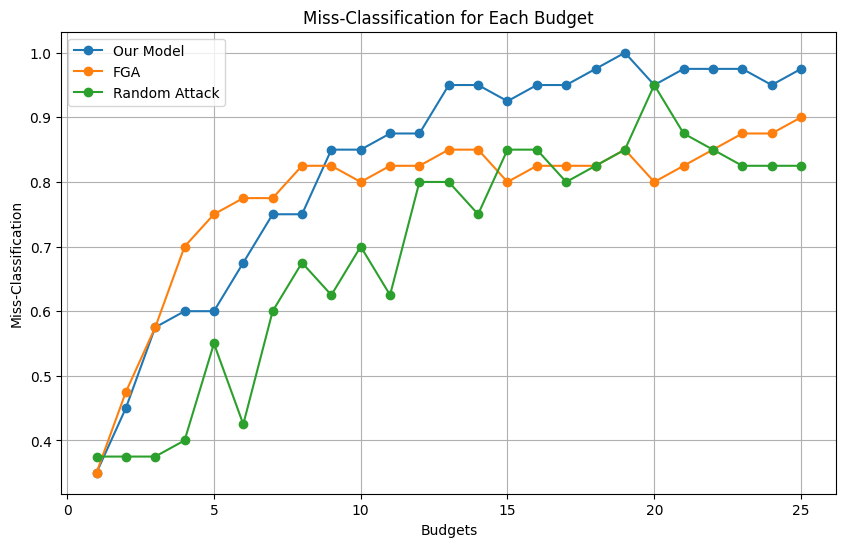

In [ ]:
# Line chart for Our_MC, FGA_MC, and RND_MC against Budgets
plt.figure(figsize=(10, 6))
plt.plot(our_model_df_1['budget_number'], our_model_df_1['miss-classification_modified'], marker='o', label='Our Model')
plt.plot(FGA_df_1['budget_number'], FGA_df_1['miss-classification_modified'], marker='o', label='FGA')
plt.plot(RND_df_1['budget_number'], RND_df_1['miss-classification_modified'], marker='o', label='Random Attack')
plt.xlabel('Budgets')
plt.ylabel('Miss-Classification')
plt.title('Miss-Classification for Each Budget')
plt.legend()
plt.grid(True)
plt.savefig('miss_classification_plot_1.png')
plt.show()


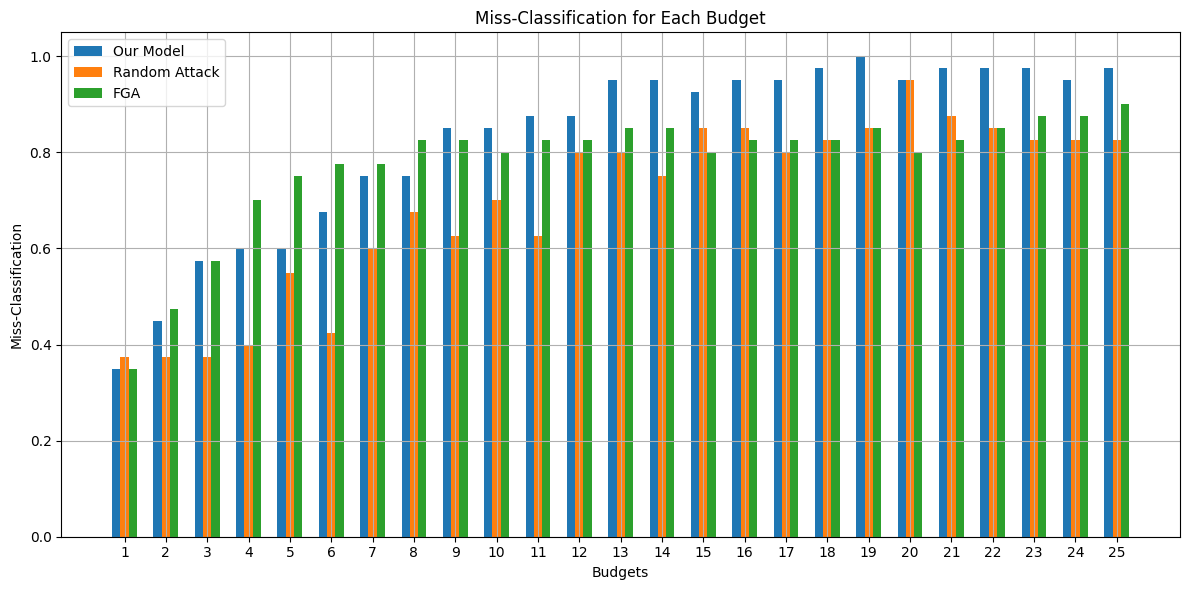

In [ ]:

# Bar chart for each budget: Our_MC, RND_MC, FGA_MC
bar_width = 0.2
index = np.arange(len(our_model_df_1['budget_number']))

plt.figure(figsize=(12, 6))

# Our_MC
plt.bar(index, our_model_df_1['miss-classification_modified'], bar_width, label='Our Model')

# RND_MC
plt.bar(index + bar_width, RND_df_1['miss-classification_modified'], bar_width, label='Random Attack')

# FGA_MC
plt.bar(index + 2 * bar_width, FGA_df_1['miss-classification_modified'], bar_width, label='FGA')

plt.xlabel('Budgets')
plt.ylabel('Miss-Classification')
plt.title('Miss-Classification for Each Budget')
plt.xticks(index + bar_width, our_model_df_1['budget_number'])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('miss_classification_plot_2.png')
plt.show()


### Time

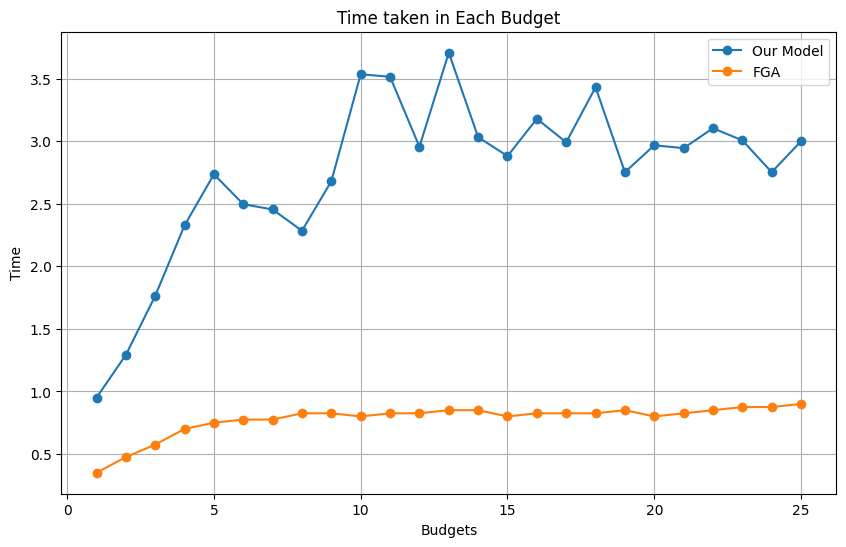

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(our_model_time_df_1['budget_number'], our_model_time_df_1['time'], marker='o', label='Our Model')
plt.plot(FGA_df_1['budget_number'], FGA_df_1['miss-classification_modified'], marker='o', label='FGA')
plt.xlabel('Budgets')
plt.ylabel('Time')
plt.title('Time taken in Each Budget')
plt.legend()
plt.grid(True)
plt.savefig('miss_classification_plot_1.png')
plt.show()